In [ ]:
# When running in Google Colab, set up environment by executing this cell
# After cloning the repo, manually move the folders "graphics" and "data" out of it (such that the notebook can access them)
!git clone https://github.com/SGrosse-Holz/2025_PolymerDynamics_Workshop
!pip install nglview==3.0.8 # nglview>=3.1.0 requires notebook>=7, but google-colab has notebook==6.5.7

from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# Install dependencies
!pip install git+https://github.com/mirnylab/nglutils
!pip install tqdm rouse rousepull noctiluca

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1' # prevent multithreading

from tqdm.auto import tqdm
from multiprocessing import Pool

import numpy as np
from scipy import optimize, linalg
from matplotlib import pyplot as plt

import rouse
import rousepull
import nglview
import nglutils as ngu
import noctiluca as nl

# Intro: Pulling on chromatin

<div align="center">
    <video width="600" height="356" 
        src="graphics/pulling_movie.mp4"
        controls>
    </video>
</div>

This movie is taken from the paper "[Live-cell micromanipulation of a genomic locus reveals interphase chromatin mechanics](https://www.science.org/doi/10.1126/science.abi9810)" and shows a genomic locus (green) being pulled through the nucleus (grey mass) by a magnet (black, on top). A cartoon representation of the system looks as follows:

<div align="center">
    <img src="graphics/pulling_sketch.jpg"
         alt="Cartoon representation of locus pulling system"
         width=400
        >
</div>

Briefly, this cell line—based on U2OS, a human cancer cell line—carries a 4Mb TetO array on chromosome 1; through a fusion protein, this array binds GFP-decorated ferritin nanoparticles, which have three important properties:
+ GFP is fluorescent, so we can **see the locus** in a (fluorescence) microscope
+ ferritin has a magnetic dipole moment, so we can **pull on the locus** by applying an inhomogeneous magnetic field. The generated force is around 1–5 pN (pico-Newton, $10^{-12}$ kg•m/s²), comparable to stall forces of single molecular motors like cohesin, condensin, and RNA Pol II; and below the tension needed to evict nucleosomes ($\sim$20 pN) or break DNA ($\sim$60 pN)
+ the ferritin cages are 24-valent, so the whole locus clumps together into a **compact, solid ball** of $\sim$500 nm diameter

<div class="alert alert-block alert-success">
    <b>Question 1</b><br>
    What kind of response would you expect when pulling on chromatin? Does the data match your expectations?
</div>

This workshop aims to give you a view into modelling and analysis of systems like this. Along the way we will learn some polymer physics, get hands-on experience with one of its most popular models (Rouse), and explore the power of scaling arguments.

# Getting started: polymer conformations

So, we need some way to understand how we would expect chromatin to behave; i.e. a model. The most accurate description would presumably be an atomistic model of the chromatin fiber. Computationally—especially for longer fibers—this is somewhere between very expensive and infeasible; so we need to simplify by omitting some details. This trade-off between accuracy and feasibility of models is omnipresent in the physics of complex systems (like chromatin).

Instead of the most accurate, let's start out with the simplest possible description of chromatin and see how far that gets us. We can think of chromatin as being made up of nucleosomes, which are connected into a long chain by linker DNA. We want to model the *conformation* $\vec{x}(s)$ of a chromosome, which describes the spatial position $\vec{x}$ for each nucleosome $s = 1, 2, \ldots$ (alternatively, we will sometimes use $s$ to label the genomic position in kb; 1kb $\approx$ 5 nucleosomes).

## Model 1: Gaussian random walk
If we know the position of nucleosome $s$, clearly the next nucleosome $s+1$ should be somewhere close-by. The simplest thing we can do is then to just place it at a random position nearby. This rule allows us to construct a conformation, by adding the independent displacements between subsequent nucleosomes:

In [128]:
# Generate conformation
stepsize = 1
steps = stepsize*np.random.normal(size=(10000, 3))
conformation = np.cumsum(steps, axis=0)

In [129]:
# Show conformation
view = ngu.xyz2nglview(conformation)

In [130]:
view # when running in Google colab, you might have to execute this cell twice before it renders

NGLWidget()

<div class="alert alert-block alert-success">
    <b>Question 2</b><br>
    Does this look like a reasonable conformation for (part of) a chromosome?
</div>

We need some way to quantify these conformations, such that we can compare different models and eventually also real data (e.g. from chromatin tracing). One useful way to characterize conformations is in terms of the *mean squared distance* between two loci at different genomic positions,
$$
R^2(\Delta s) = \left\langle \left( \vec{x}(s+\Delta s) - \vec{x}(s) \right)^2 \right\rangle\,.
$$
Or, in python:

In [5]:
def R2(x, ds):
    return np.mean( np.sum( (x[ds:]-x[:-ds])**2, axis=-1), axis=0)

The average runs over different genomic positions $s$, and we calculate the average spatial distance to a locus offset by $\Delta s$ along the backbone.

<div class="alert alert-block alert-warning">
    <b>Task 1</b><br>
    Use the <tt>conformation</tt> we generated above to calculate $R^2(\Delta s)$ for different values of $\Delta s$ and plot it. Do you notice something? It might be useful to draw the plot in log-log space, e.g. by using <tt>plt.loglog()</tt>.
</div>

### Solution to Task 1

  0%|          | 0/9999 [00:00<?, ?it/s]

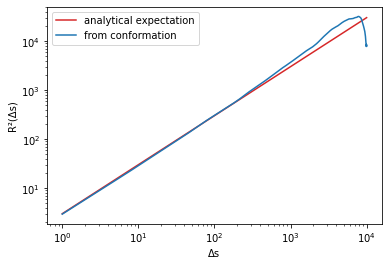

In [6]:
ds_range = np.arange(1, len(conformation))
r2 = np.array([R2(conformation, ds) for ds in tqdm(ds_range)])

plt.plot(ds_range, 3*stepsize**2*ds_range, label='analytical expectation', color='tab:red')
plt.plot(ds_range, r2, label='from conformation')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Δs')
plt.ylabel('R²(Δs)')
plt.show()

<div class="alert alert-block alert-info">
    <b>Side Quest 1</b><br>
    Prove the "analytical expectation": $R^2(\Delta s) = d\sigma^2\Delta s$, where $d = 3$ is the spatial dimension and $\sigma$ the stepsize.
</div>
<details>
    <summary>Solution to Side Quest 1</summary>
    <p><br>
        Briefly, the argument is that variances of independent random variables simply add. $R^2(\Delta s)$ is the variance of the displacement over $\Delta s$ steps, which accordingly is $\Delta s$ times the variance of a single step. Since the different coordinate dimensions are also independent, the single-step displacement has a variance of $d$ times the variance in a single coordinate direction; the latter is $\sigma^2$ by construction. So overall
        $$
        R^2(\Delta s) = d\sigma^2\Delta s\,.
        $$
        The technically more precise formulation of this argument follows below.
        <br>————————————————————————————————————————————————————<br>
        Let us write $\Delta\vec{x}(s) := \vec{x}(s+1)-\vec{x}(s)$ for the single step increment from $s$ to $s+1$. Then we have
        $$
        \left\langle \Delta\vec{x}^2 \right\rangle = \left\langle \Delta x^2 + \Delta y^2 + \Delta z^2 \right\rangle = \left\langle \Delta x^2\right\rangle + \left\langle \Delta y^2\right\rangle + \left\langle \Delta z^2\right\rangle = d\sigma^2\,,
        $$
        since (for each step) we draw each coordinate increment $\Delta x$, $\Delta y$, and $\Delta z$ independently from a normal distribution with variance $\sigma^2$.
        <br><br>
        Displacements over $\Delta s > 1$ can be written as sum of individual steps:
        $$
        \vec{x}(s+\Delta s) - \vec{x}(s) = \Delta\vec{x}(s) + \Delta\vec{x}(s+1) + \ldots + \Delta\vec{x}(s+\Delta s-1) = \sum_{i = s}^{s+\Delta s-1} \Delta\vec{x}(i)\,,
        $$
        such that
        $$
        R^2(\Delta s) = \left\langle \left(\vec{x}(s+\Delta s) - \vec{x}(s)\right)^2 \right\rangle = \sum_{i = s}^{s+\Delta s-1}\sum_{j = s}^{s+\Delta s-1} \left\langle \Delta\vec{x}(i)\Delta\vec{x}(j) \right\rangle\,.
        $$
        Different increments are independent, such that
        $$
        \left\langle \Delta\vec{x}(i)\Delta\vec{x}(j) \right\rangle = \begin{cases} 0 & \text{if $i\neq j$} \\ \left\langle\Delta\vec{x}^2(i)\right\rangle = d\sigma^2 & \text{if $i = j$} \end{cases} \quad\equiv\quad d\sigma^2 \delta_{ij}\,.
        $$
        Inserting into the above expression for $R^2(\Delta s)$ gives
        $$
        R^2(\Delta s) = d\sigma^2 \sum_{i = s}^{s+\Delta s-1}\sum_{j = s}^{s+\Delta s-1} \delta_{ij} = d\sigma^2\Delta s\,.
        $$
    </p>
</details>

## Model 2: the freely jointed chain
One particularly unrealistic aspect of the Gaussian random walk as a model for chromatin is that the linker length, i.e. the distance between subsequent nucleosomes, can vary (since it is just sampled from a Gaussian distribution). It might be more realistic to fix the linker length to a constant and only let its direction vary freely. Let's investigate this model for polymer conformations; it is called the "freely-jointed chain".

<div class="alert alert-block alert-warning">
    <b>Task 2</b><br>
    Re-using the code from the Gaussian random walk, generate a conformation with fixed linker lengths. You can achieve this for example by normalizing the displacements to a fixed length (the stepsize) before summing them. Visualize the conformation (you can use <tt>nglview</tt> as we did above, or e.g. <tt>matplotlib</tt>).
</div>

<div class="alert alert-block alert-warning">
    <b>Task 3</b><br>
    Can you tell the difference between this conformation and a Gaussian random walk? Calculate (and plot) $R^2(\Delta s)$, and compare.
</div>

### Solution to Tasks 2 & 3

In [131]:
# Generate conformation
stepsize = 1
steps = np.random.normal(size=(10000, 3))
steps *= stepsize/np.linalg.norm(steps, axis=-1, keepdims=True) # normalize steps to force fixed linker length
conformation = np.cumsum(steps, axis=0)

In [132]:
# Show conformation
view = ngu.xyz2nglview(conformation)

In [133]:
view # when running in Google colab, you might have to execute this cell twice before it renders

NGLWidget()

  0%|          | 0/9999 [00:00<?, ?it/s]

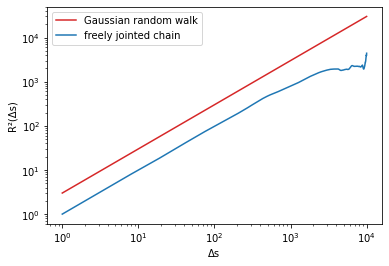

In [9]:
# Plot R²(Δs)
ds_range = np.arange(1, len(conformation))
r2 = np.array([R2(conformation, ds) for ds in tqdm(ds_range)])

plt.plot(ds_range, 3*stepsize**2*ds_range, label='Gaussian random walk', color='tab:red')
plt.plot(ds_range, r2, label='freely jointed chain')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Δs')
plt.ylabel('R²(Δs)')
plt.show()

The main difference is a prefactor 3, due to how the displacements were normalized (we set $\left\langle\Delta\vec{x}^2\right\rangle = \sigma^2 = 1$ for the freely jointed chain, while for the Gaussian random walk we had $\left\langle\Delta\vec{x}^2\right\rangle = d\sigma^2 = 3$). Qualitatively, these two models for polymer conformations are quite similar.

## Model 3: two-angle chain
The freely jointed chain still makes an approximation that probably seems outrageous when thinking of nucleosomes: namely that the angle between subsequent displacements can be arbitrary. This seems at odds with the robust structure of the nucleosome core particle; check, for example, the recent structure from [(Takizawa, et al., 2023)](https://www.rcsb.org/3d-view/7VZ4/1):

In [10]:
nglview.show_pdbid('7vz4')
# in case this doesn't render, check the link above, or https://www.rcsb.org/3d-view/7VZ4/1

NGLWidget()

The two DNA linkers connecting this nucleosome to its neighbors will form an acute angle. How does this affect our polymer conformation?

For our last toy model of chromatin conformations, we use a variant of the two-angle chain devised by [(Woodcock, et al., 1993)](https://doi.org/10.1073/pnas.90.19.9021), where the direction of the next increment is given by two angles: $\alpha\in\left[0, \pi\right]$, the "entry-exit angle", is the angle between subsequent DNA linkers that we just discussed; $\beta\in\left[0, 2\pi\right)$, the "rotation angle", is the rotation of the nucleosome around the axis of the last linker.

![Description of the angles α and β of the two-angle chain](graphics/two-angle_chain.png)

For our naive model of a chromatin fiber, we will fix $\alpha = 30\degree = \pi/6$ and choose $\beta\in\left[0, 2\pi\right)$ uniformly at random.

In [11]:
# Helper function to convert the angles α and β to cartesian displacements
def incangles2point(x_ref, beta, alpha=np.pi/6, stepsize=1):
    """
    Given the last three points on the chain, convert the increment angles to the next point

    Parameters
    ----------
    x_ref : (3, 3) array
        the last three points along the chain
    beta : float
        rotation ("dihedral") angle
    alpha : float, optional
        entry-exit angle. Defaults to 30°
    stepsize : float, optional
        linker length

    Returns
    -------
    (3,) array
        the next point on the chain
    """
    # Reference directions
    ez = x_ref[1]-x_ref[2]
    ey = np.cross(x_ref[1]-x_ref[0], x_ref[2]-x_ref[1])
    ex = np.cross(ey, ez)

    # Normalize
    ex /= np.linalg.norm(ex)
    ey /= np.linalg.norm(ey)
    ez /= np.linalg.norm(ez)

    # Get increment
    dx = stepsize*( (ex*np.cos(beta)+ey*np.sin(beta))*np.sin(alpha) + ez*np.cos(alpha) )

    return x_ref[2] + dx

In [134]:
stepsize = 1

x = np.zeros((10002, 3))
x[0] = (0, 1, 0) # dummy points to make
x[1] = (1, 0, 0) # β well-defined at the beginning
x[2] = (0, 0, 0) # start at the origin

alpha = np.pi/6  # 30°
beta = np.random.uniform(2*np.pi, size=len(x))
for i in tqdm(range(3, len(x))):
    x[i] = incangles2point(x[(i-3):i], beta[i], alpha, stepsize)

conformation = x[2:] # cut off dummy points

view = ngu.xyz2nglview(conformation)

  0%|          | 0/9999 [00:00<?, ?it/s]

In [135]:
view # when running in Google colab, you might have to execute this cell twice before it renders

NGLWidget()

This model looks visibly different from the other two. Let's quantify that in terms of $R^2(\Delta s)$:

  0%|          | 0/9999 [00:00<?, ?it/s]

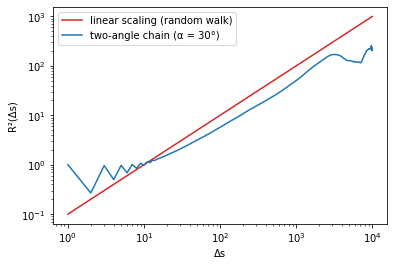

In [13]:
# Plot R²(Δs)
ds_range = np.arange(1, len(conformation))
r2 = np.array([R2(conformation, ds) for ds in tqdm(ds_range)])

plt.plot(ds_range, 1e-1*stepsize**2*ds_range, label='linear scaling (random walk)', color='tab:red')
plt.plot(ds_range, r2, label='two-angle chain (α = 30°)')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Δs')
plt.ylabel('R²(Δs)')
plt.show()

For short genomic separations, we now see a clear deviation from the random walk behavior. This makes sense, since we introduced strong (anti-)correlations at short scales. However, over distances $\gtrsim$100 nucleosomes (ca. 20kb), we recover the linear dependence that is characteristic for a random walk. So, even though the microscopic construction of the model is quite different, over large enough distances we get a random walk again!

<div class="alert alert-block alert-warning">
    <b>Task 4</b><br>
    How do the conformation and $R^2(\Delta s)$ change when you adjust $\alpha$? Use the code above to try a few different values. Can you find one that will break the random walk scaling at long distances?
    <br><br>
    <em>Advanced version:</em> so far we calculated $R^2(\Delta s)$ from a single conformation, which makes the curve unreliable especially for large $\Delta s$ (because we do not have enough data to average). Calculate an ensemble average $R^2(\Delta s)$, i.e. averaged over multiple different conformations. This should bring out the random walk scaling for large $\Delta s$ even more clearly.
</div>
<details>
    <summary>Solution to Task 4</summary>
    <p><br>
        There are exactly two values that break the long-range random walk scaling: setting $\alpha = \pi$ makes the conformation a straight line, for which $R^2(\Delta s) \propto \Delta s^2$. Conversely, setting $\alpha = 0$ (numerically, use e.g. $10^{-10}$) makes the conformation jump back and forth between two fixed points such that $R^2(\Delta s)$ becomes purely oscillatory.
        <br><br>
        For values $\alpha\in(0, \pi)$, the $R^2(\Delta s)$ curve will always transition to the random walk scaling eventually. Note, however, the change in short-time behavior: while for $\alpha < \pi/2$ we create anti-correlation ("backstepping" in the conformations) and oscillations in $R^2(\Delta s)$, setting $\alpha > \pi/2$ creates positive correlations and makes the fiber more smooth over short distances. With $\alpha = \pi/2$ we recover an almost perfect random walk scaling even for short genomic separations.
    </p>
</details>

## Universality
We just stumbled across an interesting observation: regardless* of how exactly we model our chromatin fiber, over large** genomic separations anything will behave like a random walk. This is an instance of *universality*: if we zoom out a little bit, the specific details of the model stop being relevant and we get some universal behavior. So, even if we were to build an atomistic model of the chromatin fiber, over large genomic length scales it would start following random walk statistics. This is a very useful observation: it allows us to use a very simplistic model (e.g. a Gaussian random walk) to study a complex system (chromatin) and—as long as we stay at large scales—still capture some relevant behavior.

Note that this means that we knowingly and willfully use models that get certain aspects wrong; it is then the art of the complex-systems-physicist to know when and at what scales which model is applicable or not.

<font size="1">
* within reasonably wide bounds<br>
** what exactly "large" means depends on the model; e.g. for our two-angle chain with $\alpha = 30\degree$ we got $\Delta s\gtrsim$20kb.
</font>

# Making things move: polymer dynamics

So far we looked at static polymer conformations. But, generally speaking, time exists; and things tend to move over time. Specifically, polymer conformations will fluctuate due to thermal kicks, which we will try to model here.

Let's follow the approach of the previous section: start out with a simple (but not necessarily physically accurate) prescription for how things move over short time scales and see whether we can extract some universal features.

<div class="alert alert-block alert-success">
    <b>Question 3</b><br>
    Consider a Gaussian random walk conformation and let's try to "make it move". This means that we are searching for an update rule: how can we modify the conformation such that
    <ul>
        <li>the new conformation is very similar to the old one (i.e. we want a "small" update);</li>
        <li>the new conformation is still a Gaussian random walk</li>
    </ul>
    What would you suggest?
</div>
<details>
    <summary>My proposal</summary>
    <p><br>
        We can try a resampling approach: for each update step
        <ul>
            <li>pick one of the points of the conformation</li>
            <li>check which alternative positions for this point are possible (conditional on the rest of the chain)</li>
            <li>pick one of those at random and move the point there</li>
            <li>repeat from the top</li>
        </ul>
        The main difficulty in this approach is to make sure that we maintain Gaussian random walk statistics. The key to that issue is found in Side Quest 2.
    </p>
</details><br>

<div class="alert alert-block alert-info">
    <b>Side Quest 2</b><br>
    Consider two Gaussian random variables $\Delta x_1, \Delta x_2 \sim\text{iid }\mathcal{N}(0, \sigma^2)$ ("independent and identically distributed, namely Gaussian with mean 0 and variance $\sigma^2$"). Show that the conditional distribution of $\Delta x_1$ given the sum $\Delta x_\text{total} := \Delta x_1 + \Delta x_2$ is given by
    $$
    \left.\Delta x_1\middle|\Delta x_\text{total}\right. \sim \mathcal{N}\left(\frac{\Delta x_\text{total}}{2}, \frac{\sigma^2}{2}\right)\,,
    $$
</div>
<details>
    <summary>Solution to Side Quest 2</summary>
    <p><br>
        Consider the joint distribution
        $$
        p(\Delta x_1, \Delta x_2) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x_1^2}{2\sigma^2}-\frac{\Delta x_2^2}{2\sigma^2}\right)\,.
        $$
        Substituting $\Delta x_2 = \Delta x_\text{total} - \Delta x_1$ gives
        $$
        p(\Delta x_1, \Delta x_\text{total}) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x_1^2}{2\sigma^2}-\frac{(\Delta x_\text{total}-\Delta x_1)^2}{2\sigma^2}\right) \,.
        $$
        We then rewrite the expression in the numerator in the exponential:
        $$
        \Delta x_1^2 + (\Delta x_\text{total}-\Delta x_1)^2 = 2\Delta x_1^2 - 2\Delta x_\text{total}\Delta x_1 + \Delta x_\text{total}^2 = 2\left(\Delta x_1 - \frac{\Delta x_\text{total}}{2}\right)^2 + \frac{1}{2}\Delta x_\text{total}^2 \,,
        $$
        such that ultimately
        $$
        p(\Delta x_1, \Delta x_\text{total}) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\left(\Delta x_1 - \frac{\Delta x_\text{total}}{2}\right)^2}{\sigma^2} - \frac{\Delta x_\text{total}^2}{4\sigma^2} \right) = \mathcal{N}\left(\Delta x_1; \frac{\Delta x_\text{total}}{2}, \frac{\sigma^2}{2}\right) \mathcal{N}\left(\Delta x_\text{total}; 0, 2\sigma^2\right) = p\left(\Delta x_1\middle|\Delta x_\text{total}\right)p(\Delta x_\text{total})\,,
        $$
        where $\mathcal{N}(x; \mu, \Sigma)$ signifies the PDF of a normal distribution in variable $x$ with mean $\mu$ and variance $\Sigma$. We can directly read off the conditional distribution we needed, as well as the marginal distribution for $\Delta x_\text{total}$.
    </p>
</details>

In [14]:
# Implementation of Side Quest 2
def sample_constrained_Gaussian(dx_total, stepsize=1):
    """
    Sample dx1, dx2 ~ Gaussian subject to the constraint dx1 + dx2 = dx_total

    Parameters
    ----------
    dx1_total : (3,) array
        the sum of the two random variables to constrain to

    Returns
    -------
    (3,) array
        displacement dx1. Use dx2 = dx_total - dx1 if needed
    """
    mean = np.asarray(dx_total)/2
    std  = stepsize/np.sqrt(2)
    return np.random.normal(loc=mean, scale=std)

We now have everything we need to run the resampling scheme: at each step, we pick a point $s$ along the chain at random. We calculate the displacement $\Delta \vec{x}_\text{total} = \vec{x}(s+1) - \vec{x}(s-1)$ between its neighbors and resample $\vec{x}(s)$ conditional on this total displacement; then iterate.

In [15]:
# Generate initial conformation
stepsize = 1
dx = stepsize*np.random.normal(size=(100, 3))
x = np.cumsum(dx, axis=0)

# Run resampling scheme
all_x = [x.copy()]
for i in tqdm(range(100)):
    for j in range(1): # How many steps to take before saving a new conformation
        n_change = np.random.randint(len(x))
        if n_change == 0:
            x[0] = np.random.normal(loc=x[1], scale=stepsize)
        elif n_change == len(x)-1:
            x[-1] = np.random.normal(loc=x[-2], scale=stepsize)
        else:
            x[n_change] = x[n_change-1] + sample_constrained_Gaussian(x[n_change+1]-x[n_change-1], stepsize)
    all_x.append(x.copy())

x = np.asarray(all_x)

  0%|          | 0/100 [00:00<?, ?it/s]

In [136]:
view = ngu.xyz2nglview(x)

In [137]:
view # when running in Google colab, you might have to execute this cell twice before it renders

NGLWidget()

<div class="alert alert-block alert-warning">
    <b>Task 5.0</b><br>
    Play with the above dynamics. Specifically, increase the range of <tt>j</tt> (steps per frame) e.g. in steps of 10x to look at the dynamics on different time scales.
</div>

<div class="alert alert-block alert-warning">
    <b>Task 5.1: Recoil</b><br>
    Modify the initial conformation, e.g. by stretching it (add a constant offset to the increments when generating the conformation). Run the dynamics. What can you observe? Does this seem realistic?
    <br>
    <font size=1>Note: you might have to run <em>many</em> resampling steps to see the whole chain move.</font>
</div>

<div class="alert alert-block alert-info">
    <b>Side Quest 3</b><br>
    In the resampling scheme above, we consider free ends. Can you change those boundary conditions? Try e.g. tethering the beginning of the chain to the origin.
</div>
<details>
    <summary>Solution to Side Quest 3</summary><br>
    Replace the line
    <pre><code>
        x[0] = np.random.normal(loc=x[1], scale=stepsize)
    </code></pre>
    by
    <pre><code>
        x[0] = sample_constrained_Gaussian(x[1], stepsize)
    </code></pre>
</details><br>

<div class="alert alert-block alert-warning">
    <b>Task 5.2: Spring in viscous medium</b><br>
    Consider a ball of radius $r$, which is attached to the coordinate origin by a Hookean spring with spring constant $k$. We immerse the whole system in a viscous solvent (e.g. water), such that the finite size of the ball gives it a finite drag coefficient $\gamma$. We consider the overdamped case, i.e. neglect inertial effects due to the mass of the ball. The displacement $x$ of the ball from the origin then follows the differential equation
    $$
    \gamma\frac{\mathrm{d}x}{\mathrm{d}t} = -kx(t)\,.
    $$
    Solve this equation, subject to the initial condition $x(t=0) = x_0$. Compare with your results for the stretched polymer.
    <br>
    <font size=1>Hint: you can probably find the solution by guessing. Which function is its own derivative?</font>
</div>

### Solution to Task 5

To improve statistics, let's run a few repeats of the recoil scheme. The mean recoil behavior we get looks much like a simple exponential. Incidentally, this is also the behavior of the Hookean spring in viscous solvent:
$$
x(t) = x_0\exp\left(-\frac{k}{\gamma}t\right)\,.
$$
This behavior is referred to as an *entropic spring*: in contrast to the Hookean spring, where elasticity is due to energy stored in the spring when deforming it, the recoil of the stretched polymer is a purely entropic effect. The resulting behavior, however, is basically the same.

In [39]:
def run_recoil(seed):
    np.random.seed(seed) # need to seed RNG for parallelization
    
    # Set up
    stepsize = 1
    dx = stepsize*np.random.normal(size=(100, 3))
    dx[:, 0] += stepsize # stretch the chain
    x = np.cumsum(dx, axis=0)
    
    # Run resampling scheme
    all_x = [x.copy()]
    for i in range(1000):
        for j in range(1000): # How many steps to take before saving a new conformation
            n_change = np.random.randint(len(x))
            if n_change == 0:
                x[0] = np.random.normal(loc=x[1], scale=stepsize)
            elif n_change == len(x)-1:
                x[-1] = np.random.normal(loc=x[-2], scale=stepsize)
            else:
                x[n_change] = x[n_change-1] + sample_constrained_Gaussian(x[n_change+1]-x[n_change-1], stepsize)
        all_x.append(x.copy())
    
    x = np.asarray(all_x)
    x_end_to_end = x[:, -1, 0] - x[:, 0, 0]
    return x_end_to_end

# The implementation we are using is not particularly efficient; so let's speed things up by parallelization
N_traj = 10 # the more the better (but longer runtime)
with Pool() as mypool:
    imap = mypool.imap_unordered(run_recoil, np.random.randint(1<<31, size=N_traj))
    imap = tqdm(imap, total=N_traj)
    trajectories = np.array(list(imap))

  0%|          | 0/10 [00:00<?, ?it/s]

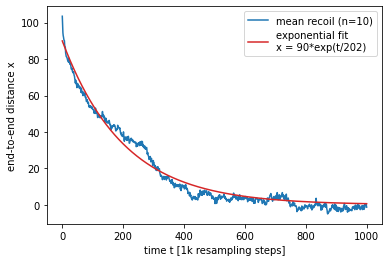

In [40]:
mean_recoil = np.mean(trajectories, axis=0)
t_plot = np.arange(len(mean_recoil))

def fitfun(t, A, B): return A*np.exp(-t/B)
popt, _ = optimize.curve_fit(fitfun, t_plot, mean_recoil, p0=(100, 100))

plt.plot(t_plot, mean_recoil, label=f'mean recoil (n={N_traj})')
plt.plot(t_plot, fitfun(t_plot, *popt), color='tab:red',
         label=f'exponential fit\nx = {popt[0]:.3g}*exp(t/{popt[1]:.3g})',
        )

plt.legend()
plt.xlabel('time t [1k resampling steps]')
plt.ylabel('end-to-end distance x')
# plt.yscale('log')
plt.show()

# The Rouse model

In the previous section, we endowed a Gaussian random walk with (somewhat artificial) dynamics and noticed that its mean recoil behavior from a uniformly stretched state resembles that of a simple Hookean spring. It stands to reason (though we will not demonstrate this) that this behavior is again *universal*; i.e. regardless of how exactly we set up the microscopic structure and dynamics of our polymer model, the behavior for reasonably long chains over reasonably long times should always be similar.

<div class="alert alert-block alert-danger">
    <b>If you're extra motivated</b><br>
    Support the universality claim: come up with dynamics for the freely jointed and/or the two-angle chain (or any other ensemble of conformations, e.g. random walk on a lattice) and check that recoil after stretching is indeed still Hookean.
</div>

This universality claim again allows us to construct a reasonably simple model that captures the behavior we would generally expect for polymers, regardless of microscopic details. Namely, if a short stretch of polymer behaves like a single spring with a viscous ball at the end ("monomer"), then a long stretch of polymer should resemble a string of such springs and balls. This construction was proposed by [(Rouse, 1953)](https://doi.org/10.1063/1.1699180) and is accordingly known as the **Rouse model of polymer dynamics**. Note that Rouse in his original paper refers to "submolecules" instead of "monomers": the idea is really that each of the "spring+ball" blocks in the model represents the effective behavior of a short stretch of the real polymer; the "monomers" we talk about do not correspond to any "smallest building block" of the real system.

<center>
<div>
<img src="graphics/Rouse_sketch.png" width="700"/>
</div>
<font size=1>Sketch of a Rouse polymer</font>
</center>

Let's assemble the equations of motion for this system. We assume that the monomers have a friction constant $\gamma$ and the springs a spring constant $k$. Each monomer $s$ experiences the following forces:
+ $F_\text{spring left} := k\left[\vec{x}(s-1) - \vec{x}(s)\right]$ from the spring connecting it to the monomer on the left,
+ $F_\text{spring right} := k\left[\vec{x}(s+1) - \vec{x}(s)\right]$ from the spring connecting it to the monomer to the right.
+ $F_\text{solvent friction} := -\gamma\dot{x}$ from friction with the solvent.

Newton's second law for one of the monomers now reads
$$
F_\text{spring left} + F_\text{spring right} + F_\text{solvent friction} \equiv F_\text{total} = m\ddot{x}\,.
$$
We neglect inertial effects (i.e. set $m = 0$), such that the above simply becomes a force balance equation, $F_\text{total} = 0$. Inserting the individual terms then gives
\begin{align}
\gamma\dot{\vec{x}}(0) {}={}& k\left[\vec{x}(1)-\vec{x}(0)\right] \\
\gamma\dot{\vec{x}}(s) {}={}& k\left[\vec{x}(s-1)-2\vec{x}(0)+\vec{x}(s+1)\right] \qquad\text{for $0 < s < S$} \\
\gamma\dot{\vec{x}}(S) {}={}& k\left[\vec{x}(S-1)-\vec{x}(S)\right] \\
\end{align}
where $s = 0,\ldots,S$ is the monomer index. Note that there are $S$ springs and $S+1$ monomers (since we include the index 0).

All the monomer positions together constitute the *conformation* of the chain. We write $X := \left(\vec{x}(0), \vec{x}(1), \ldots, \vec{x}(S)\right)^T$, which allows us to rewrite the equation of motion as
$$
\gamma\dot{X} = -kBX\,,
$$
with the *connectivity matrix*
$$
B = \begin{pmatrix} 1 & -1 & & & & \\ -1 & 2 & -1 & & & \\ & -1 & 2 & -1 & & & \\ & & & \ddots & & \\ & & & -1 & 2 & -1 \\ & & & & -1 & 1 \end{pmatrix}\,.
$$
Note that formally this looks a lot like the simple Hookean spring we discussed in Task 5.2! And indeed, the formal solution is the same:
$$
X(t+\Delta t) = \exp\left(-\frac{k}{\gamma}B\Delta t\right)X(t)\,.
$$
The "only" difference is that now the exponential becomes a *matrix exponential*. Don't panic if you're unfamiliar with that concept; the important point for now is that such an expression can be evaluated numerically, e.g. by <code>scipy.linalg.expm</code>.

Note what just happened: we showed that—under the Rouse model—the "new" conformation $X(t+\Delta t)$ is given by a simple matrix product of $\exp\left(-\frac{k}{\gamma}B\Delta t\right)$ with the "old" conformation $X(t)$. The exponential expression is therefore known as a *propagator*—it *propagates* conformations forward by a fixed amount of time $\Delta t$. Note also that we started out by considering only the *mean* recoil behavior, but are ignoring fluctuations for now. We will bring those back in a later section.

<div class="alert alert-block alert-warning">
    <b>Task 6</b><br>
    Calculate the (mean) recoil behavior of a Rouse chain from the stretched state. You can do this by repeated application of the propagator described above, setting $k = 1 = \gamma$ for simplicity. Also for simplicity, work in 1D, such that $X(t)$ becomes an $S$-dimensional vector (instead of a $S\times 3$-dimensional matrix).
</div>

<div class="alert alert-block alert-warning">
    <b>Task 6.1</b><br>
    Vary the number of monomers $S$. How does the relaxation time scale change?
</div>

### Solution to Task 6

  0%|          | 0/500 [00:00<?, ?it/s]

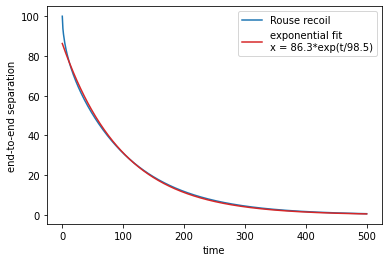

In [51]:
S    = 100 # number of monomers
dt   = 10  # time step
N_dt = 500 # total number of time steps

# Assemble the propagator
B = np.diag(2*np.ones(S+1)) - np.diag(np.ones(S), 1) - np.diag(np.ones(S), -1)
B[0, 0] = B[-1, -1] = 1
propagator = linalg.expm(-B*dt)

# Compute subsequent conformations
all_X = [np.arange(S+1)] # stretched initial conformation
for _ in tqdm(range(N_dt)):
    all_X.append(propagator @ all_X[-1])
    
all_X = np.array(all_X)

# Extract end-to-end distance
x_end_to_end = all_X[:, -1] - all_X[:, 0]
t_plot = np.arange(len(x_end_to_end))

# Fit an exponential
def fitfun(t, A, B): return A*np.exp(-t/B)
popt, _ = optimize.curve_fit(fitfun, t_plot, x_end_to_end, p0=(100, 100))

# Plot everything
plt.plot(t_plot, x_end_to_end, label=f'Rouse recoil')
plt.plot(t_plot, fitfun(t_plot, *popt), color='tab:red',
         label=f'exponential fit\nx = {popt[0]:.3g}*exp(t/{popt[1]:.3g})',
        )

plt.legend()
plt.xlabel('time')
plt.ylabel('end-to-end separation')
plt.show()

Again we get a nice exponential recoil. Note, however, that this is now a fully analytical solution; no sampling or incremental updating necessary.

By changing the number of monomers $S$ (e.g. to 50 and/or 200) one can check that relaxation time scales as $S^2$.

## External force

Remember that we derived the equation of motion of the Rouse model,
$$
\gamma\dot{X} = -kBX\,,
$$
from a simple force balance:
$$
0 = -\gamma\dot{X} - kBX \equiv F_\text{friction} + F_\text{springs}\,.
$$
We can thus also insert an external force, such that we can describe the pulling experiment mentioned in the Introduction:
$$
0 = F_\text{friction} + F_\text{springs} + F_\text{external} \qquad\Leftrightarrow\qquad \gamma\dot{X} = -kBX + F_\text{external}\,.
$$

<div class="alert alert-block alert-info">
    <b>Side Quest 4</b><br>
    Solve the above equation for the Rouse model under an external force, subject to the initial condition $X(t=0) = X_0$.
</div>
<details>
    <summary>Solution to Side Quest 4</summary><br>
    It can be checked by differentiation that
    $$
    X(t) = \exp\left(-\frac{k}{\gamma}Bt\right)X_0 + \frac{1}{\gamma}\int_0^t\mathrm{d}\tau\, \exp\left(-\frac{k}{\gamma}B(t-\tau)\right) F_\text{external}(t)
    $$
    solves the equation of motion.
</details><br>

Let's try to model the chromosome pulling experiment. We use the <code>rouse</code> python package to evaluate the above solution numerically and study a Rouse chain, pulled on the central monomer.

In [17]:
# Set up a chain with 100 monomers in 1D (and no thermal fluctuations)
N = 100
d = 1
model = rouse.Model(N=N, d=d, D=0)
model.F[N//2] = 1    # pulling on the central monomer
X = np.zeros((N, d)) # start from equilibrium (remember that for now X(t) is the *mean* conformation)
dt = 1               # time step

# Initialize model
# (mostly precalculating the propagator for a given time step)
model.update_dynamics(dt=dt)

# Evaluate for a few time steps
all_X = [X.copy()]
for _ in tqdm(range(100)):
    all_X.append(model.evolve(all_X[-1]))
all_X = np.array(all_X)

  0%|          | 0/100 [00:00<?, ?it/s]

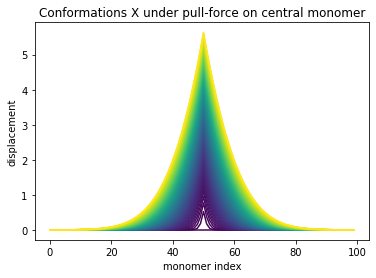

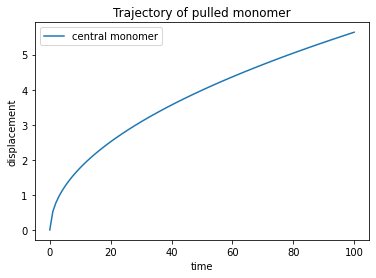

In [26]:
# Plot resulting conformations
for i in range(len(all_X)):
    color = plt.cm.viridis(i/(len(all_X)-1))
    plt.plot(all_X[i], color=color)

plt.xlabel('monomer index')
plt.ylabel('displacement')
plt.title('Conformations X under pull-force on central monomer')

plt.show()

# Plot position of the central monomer (the pulled one) over time
plt.plot(all_X[:, N//2], label='central monomer')

tplot = np.arange(len(all_X))
# plt.plot(tplot, 0.565*np.sqrt(tplot), color='tab:red', label='"educated guess"')

plt.legend()
plt.xlabel('time')
plt.ylabel('displacement')
plt.title('Trajectory of pulled monomer')

plt.show()

<div class="alert alert-block alert-warning">
    <b>Task 7</b><br>
    Try to replicate the repeated pull–release setup from the experiment: after the first pull (above) set the force to 0 and let the chain relax; then pull again; etc. To update the external force in the model, use<br>
    <pre><code>model.F[...] = ...
model.update_dynamics() # <-- important to update the propagator properly
</code></pre>
</div>

### Solution to Task 7

In [31]:
# Set up a chain with 100 monomers in 1D (and no thermal fluctuations)
N = 100
d = 1
model = rouse.Model(N=N, d=d, D=0)
X = np.zeros((N, d)) # start from equilibrium (remember that for now X(t) is the *mean* conformation)
dt = 10              # let's take 10 time steps of length 10 instead of 100 time steps of length 1 per pull/release

# Evaluate 5 pull-release cycles
all_X = [X.copy()]
for i in tqdm(range(5)):
    # Pull
    model.F[N//2] = 1
    model.update_dynamics(dt)
    for _ in range(10):
        all_X.append(model.evolve(all_X[-1]))

    # Release
    model.F[N//2] = 0
    model.update_dynamics(dt)
    for _ in range(10):
        all_X.append(model.evolve(all_X[-1]))
        
all_X = np.array(all_X)

  0%|          | 0/5 [00:00<?, ?it/s]

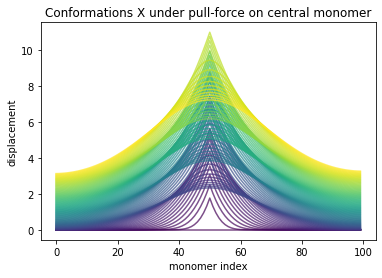

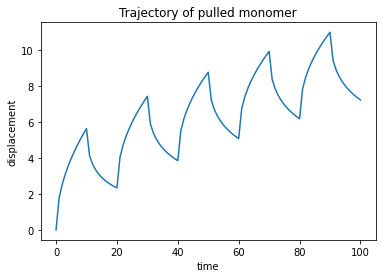

In [33]:
# Plot resulting conformations
for i in range(len(all_X)):
    color = plt.cm.viridis(i/(len(all_X)-1), alpha=0.7)
    plt.plot(all_X[i], color=color)

plt.xlabel('monomer index')
plt.ylabel('displacement')
plt.title('Conformations X under pull-force on central monomer')

plt.show()

# Plot position of the central monomer (the pulled one) over time
plt.plot(all_X[:, N//2])

plt.xlabel('time')
plt.ylabel('displacement')
plt.title('Trajectory of pulled monomer')

plt.show()

This already looks a little bit like the experimental data! Note, however, an issue: over long times the chain starts moving as a whole and displacement becomes linear. This seems unrealistic for a chromosome, which is presumably long enough that we never pull the whole chain through the nucleus. How much longer can we make the chain?

## Continuum limit

Recall the equation of motion for a monomer $s$ of the Rouse chain:
$$
\gamma\dot{x}(s) = k\left[x(s-1) - 2x(s) + x(s+1)\right] + F_\text{external}(s)\,.
$$
The term in the square brackets kind of looks like a second derivative... can we make use of that?

Remember that each spring+ball "submolecule" of the Rouse chain effectively describes a short stretch of the "real" polymer. We argued above that, instead of describing this submolecule explicitly (as we did e.g. with the Gaussian random walk with resampling dynamics), we can just approximate it as a spring+ball "monomer" and chain many of those together into a long polymer. The resulting Rouse model turned out to be quite handy. So what if we use that to also describe the internal dynamics of the "submolecules" as well?

Let's split each submolecule $s$ into $N$ chunks of length $\Delta s = 1/N$ each. Our original polymer of $S$ submolecules has now become a chain of $S\times N$ smaller chunks, each following the equation of motion
\begin{align}
\tilde\gamma\dot{x}(s) {}={}& \tilde k\left[x(s-\Delta s) - 2x(s) + x(s+\Delta s)\right] + \tilde F_\text{external}(s) \\[1em]
{}={}& \tilde k\Delta s^2 \frac{\displaystyle\frac{x(s+\Delta s) - x(s)}{\Delta s} - \frac{x(s) - x(s+\Delta s)}{\Delta s}}{\Delta s} + \tilde F_\text{external}(s) \,,
\end{align}
where we use $\tilde\gamma$, $\tilde k$, and $\tilde F$ to indicate that the model parameters have to be adjusted to account for the fact that now we are considering smaller chunks instead of whole submolecules. E.g. one might expect that $\tilde\gamma = \gamma/N = \gamma\Delta s$ and $F(s) = \sum_{s \leq s' < s+1}\tilde F(s') \simeq N \tilde F(s)$. Then also positing that $\tilde k = \kappa / \Delta s$, we get
$$
\gamma\Delta s\dot{x}(s) = \frac{\kappa}{\Delta s}\Delta s^2 \frac{\displaystyle\frac{x(s+\Delta s) - x(s)}{\Delta s} - \frac{x(s) - x(s+\Delta s)}{\Delta s}}{\Delta s} + \Delta s F(s)\,,
$$
or, dividing out $\Delta s$,
$$
\gamma\dot{x}(s) = \kappa \frac{\displaystyle\frac{x(s+\Delta s) - x(s)}{\Delta s} - \frac{x(s) - x(s+\Delta s)}{\Delta s}}{\Delta s} + F(s)\,.
$$

The number $N$ that we subdivided the submolecule into is completely arbitrary; so we can make it large, $N\to\infty$. Consequently, $\Delta s\to 0$ and the double fraction becomes a second derivative:
$$
\gamma\partial_t x(s, t) = \kappa\partial_s^2 x(s, t) + F(s, t)\,.
$$
This is the equation of motion of the **continuous Rouse model**.

To recap:
+ we noticed that we can replace each of the "submolecules" in the Rouse model with another (finer) Rouse chain of length $N$.
+ since $N$ is arbitrary, we can take $N\to\infty$, known as the *continuum limit*. In this limit, we describe each submolecule of the original chain by an infinite number of infinitesimal "monomers"; i.e. this construction produces a polymer $x(s)$ with continuous backbone coordinate, $s\in\mathbb{R}$.
+ the dynamics of this continuous chain are given by the above equation of motion.

Along the way, we sneakily dropped the boundary conditions at $s=0$ and $s=S$; instead, we just let $s\in\mathbb{R}$. This means that we now consider an infinitely long polymer, which seems appropriate for a chromosome of which we pull only a small part. This should fix our issue with whole chain motion from Task 7.

<div class="alert alert-block alert-warning">
    <b>Task 8.0</b><br>
    Solve the above equation of motion for the continuous Rouse model, starting from an initial conformation $x(s, 0)$.
</div>

<div class="alert alert-block alert-warning">
    <b>Task 8.1</b><br>
    Specialize the solution of Task 8.0 to the following case: pulling on a specific genomic locus (i.e. $F(s, t) = F(t)\delta(s)$, $\delta(s)$ being <em>Dirac's $\delta$ distribution</em>) and tracking the position of that same locus (i.e. evaluating $x(t) := x(0, t)$). Assume that $x(s, 0) = 0\,\forall s$.
</div>

<div class="alert alert-block alert-warning">
    <b>Task 8.2</b><br>
    How does the locus in Task 8.1 move under a constant force? Does this match our results from the discrete Rouse model (above Task 7)?
</div>

<div class="alert alert-block alert-warning">
    <b>Task 8.3</b><br>
    What about a step-wise constant force? Calculate the trajectory for a force of the form
    $$
    F(t) = f_i\quad\text{for $i = 0, 1, \ldots$ and $t_{i-1} \leq t < t_i$.}
    $$
    Set $t_0 = 0$ and assume that $F(t) = 0\,\forall t < 0$. It should be enough to calculate the values of $x(t_i)$ (i.e. evaluate the trajectory only at the points where the force changes its value).
</div>

<details>
    <summary>Solution to Task 8.0</summary><br>
    The solution strategy here is <em>ex machina</em>: recognize that this is an inhomogeneous partial differential equation with one temporal and two spatial derivatives; otherwise known as the <em>diffusion</em> or <em>heat equation</em>. It is solved by a <em>Weierstraß transform</em>, i.e. convolution with a Gaussian with increasing width (imagine a sharply peaked concentration profile flattening over time). One can check by differentiation that
    $$
    x(s, t) = \int_\mathbb{R}\mathrm{d}\sigma\, \frac{\mathrm{e}^{-\frac{\gamma(\sigma - s)^2}{4\kappa t}}}{\sqrt{4\pi\frac{\kappa}{\gamma} t}}x(\sigma, 0) + \int_\mathbb{R}\mathrm{d}\sigma\, \int_0^t\mathrm{d}\tau\, \frac{\mathrm{e}^{-\frac{\gamma(\sigma - s)^2}{4\kappa (t-\tau)}}}{\sqrt{4\pi\gamma\kappa (t-\tau)}}F(\sigma, \tau)\,.
    $$
</details>
<details>
    <summary>Solution to Task 8.1</summary><br>
    $x(s, 0) = 0$ makes the first term (the one from the initial condition) vanish. Evaluating the rest at $s=0$ and inserting $F(s, t) = F(t)\delta(s)$ then gives
    $$
    x(t) := x(0, t) = \int_\mathbb{R}\mathrm{d}\sigma\, \int_0^t\mathrm{d}\tau\, \frac{\mathrm{e}^{-\frac{\gamma\sigma^2}{4\kappa (t-\tau)}}}{\sqrt{4\pi\gamma\kappa (t-\tau)}}F(\tau)\delta(\sigma)\,.
    $$
    The integral over $\sigma$ is now trivial (due to the $\delta(s)$), such that
    $$
    x(t) = \int_0^t\mathrm{d}\tau\, \frac{F(\tau)}{\sqrt{4\pi\gamma\kappa (t-\tau)}}\,.
    $$
</details>
<details>
    <summary>Solution to Task 8.2</summary><br>
    Set $F(t) \equiv F = \text{const.}$ to find
    $$
    x(t) = \frac{F}{\sqrt{4\pi\gamma\kappa}} \int_0^t \frac{\mathrm{d}\tau}{\sqrt{t-\tau}} = \frac{F}{\sqrt{4\pi\gamma\kappa}} \int_0^t \frac{\mathrm{d}\tau}{\sqrt{\tau}} = \frac{F\sqrt{t}}{\sqrt{\pi\gamma\kappa}}\,.
    $$
    So $x(t)\propto\sqrt{t}$. This is the "educated guess" we plotted together with the results from the discrete Rouse model.
</details>
<details>
    <summary>Solution to Task 8.3</summary><br>
    We split the integration region at the force change points:
    \begin{align}
    x(t_i) {}={}& \frac{1}{\sqrt{\pi\gamma\kappa}}\int_0^{t_i}\mathrm{d}\tau\,\frac{F(\tau)}{2\sqrt{t_i-\tau}} \\
    {}={}& \frac{1}{\sqrt{\pi\gamma\kappa}}\sum_{j=1}^i \int_{t_{j-1}}^{t_j}\mathrm{d}\tau\,\frac{f_j}{2\sqrt{t_i-\tau}} \\
    {}={}& \frac{1}{\sqrt{\pi\gamma\kappa}}\sum_{j=1}^i \int_{t_{j-1}}^{t_j}\left(\sqrt{t_i - t_{j-1}} - \sqrt{t_i - t_j}\right) f_j \\
    {}\equiv{}& \frac{1}{\sqrt{\pi\gamma\kappa}}\sum_{j=1}^N M_{ij} f_j \,.
    \end{align}
    So, by discretizing, we can rewrite the (linear) integral as a linear transform between the force profile $\mathbf{f} := \left(f_0, f_1, \ldots, f_N\right)^T$ and the trajectory $\mathbf{x} := \left(x(t_0), x(t_1), \ldots, x(t_N)\right)^T$, given by the matrix
    $$
    M := \begin{pmatrix} \sqrt{t_1} & & & \\ \sqrt{t_2}-\sqrt{t_2-t_3} & \sqrt{t_2-t_1} & & \\ \sqrt{t_3}-\sqrt{t_3-t_1} & \sqrt{t_3-t_1}-\sqrt{t_3-t_2} & \sqrt{t_3-t_2} & \\ \vdots & & & \ddots \end{pmatrix}\,.
    $$
    This matrix is invertible; so we get a one-to-one mapping between force profiles and trajectories:
    $$
    \mathbf{x} = \frac{1}{\sqrt{\pi\gamma\kappa}}M\mathbf{f} \qquad\Leftrightarrow\qquad \mathbf{f} = \sqrt{\pi\gamma\kappa}M^{-1}\mathbf{x}\,.
    $$
    This allows us to infer the force acting on a locus from its movement!
</details>

A handy implementation of this solution is available in the <code>rousepull</code> package:

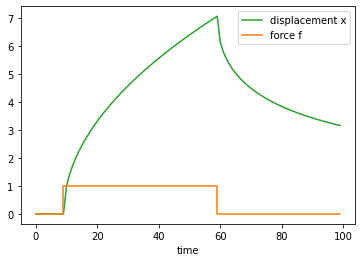

In [59]:
# Set up a force profile, i.e. how the force changes over time
# As an example, we set up a single pull
f = np.zeros(100)
f[10:60] = 1
t = np.arange(len(f)) # time index

# Predict the locus trajectory
I = rousepull.ForceInference(t)
x = I._generate(f)

# Plot
plt.plot(t, x, color='tab:green', label='displacement x')
plt.step(t, f, where='pre', color='tab:orange', label='force f')

plt.legend()
plt.xlabel('time')

plt.show()

What would the force have to look like to keep the locus in place after the pull?

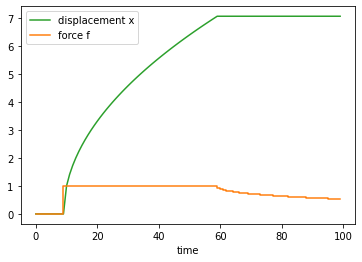

In [60]:
x[60:] = x[59]

# Infer the force
f = I._infer(x)

# Plot
plt.plot(t, x, color='tab:green', label='displacement x')
plt.step(t, f, where='pre', color='tab:orange', label='force f')

plt.legend()
plt.xlabel('time')

plt.show()

Note that the force needed to pin the locus at a fixed position decreases over time. This is because the polymer relaxes towards this new position of the locus and accordingly exerts less restoring force.

## Force inference on real data

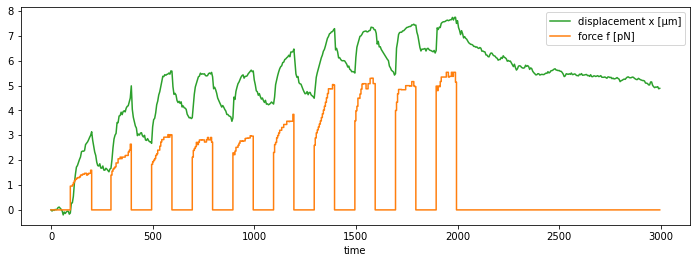

In [90]:
# Load the force and trajectory data
arr = np.genfromtxt('data/20200304_100s-PR_Fxyz.csv', skip_header=1, delimiter=';')
t_force = arr[:, 0].astype(int)
f = -arr[:, 2] # (pN); fix sign

arr = np.genfromtxt('data/20200304_100s-PR_trajectory.trk2', skip_header=1, delimiter='\t')
pixel_size = 0.13 # μm
t_trajectory = arr[:, 0].astype(int)
x = (arr[0, 2] - arr[:, 2])*pixel_size # (μm); fix sign

t, i_force, i_trajectory = np.intersect1d(t_force, t_trajectory, return_indices=True)
t = t*5 # 5 second frame-rate
f = f[i_force]
x = x[i_force]

# Plot
plt.figure(figsize=[12, 4])

plt.plot(t, x, color='tab:green', label='displacement x [μm]')
plt.step(t, f, where='pre', color='tab:orange', label='force f [pN]')

plt.legend()
plt.xlabel('time')

plt.show()

<div class="alert alert-block alert-warning">
    <b>Task 9</b><br>
    Run the force inference on the real data. Try both directions: predict the trajectory from the measured force (and then compare to the observed trajectory); and infer the force from the observed trajectory (and then compare to the measured force). Does this data match our expectations from the Rouse model?
</div>

### Solution to Task 9

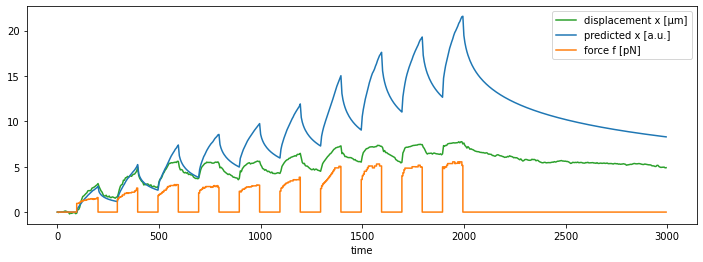

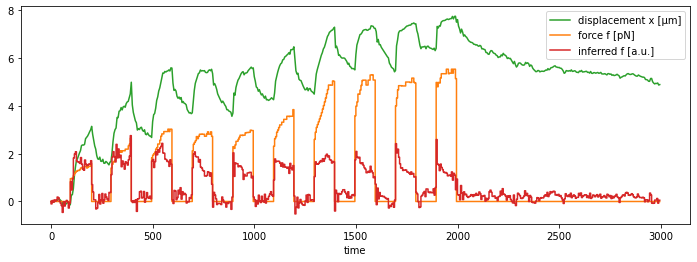

In [97]:
# Run inference/prediction
I = rousepull.ForceInference(t, Gamma=0.001627) # Gamma: calibration factor
x_predicted = I._generate(f)
f_inferred  = I._infer(x)

# Plot
plt.figure(figsize=[12, 4])

plt.plot(t, x, color='tab:green', label='displacement x [μm]')
plt.plot(t, x_predicted, color='tab:blue', label='predicted x [a.u.]')
plt.step(t, f, where='pre', color='tab:orange', label='force f [pN]')

plt.legend()
plt.xlabel('time')

plt.show()

plt.figure(figsize=[12, 4])

plt.plot(t, x, color='tab:green', label='displacement x [μm]')
plt.step(t, f, where='pre', color='tab:orange', label='force f [pN]')
plt.step(t, f_inferred, where='pre', color='tab:red', label='inferred f [a.u.]')

plt.legend()
plt.xlabel('time')

plt.show()

Overall, not too bad; especially the first two pulls seem to fit the theory quite well. After that, however, we get noticeable mismatches: the locus moves less than expected. Alternatively (bottom plot): we need more force than expected to move the locus as observed; this suggests some additional force absorption not captured by the Rouse model. Note, however, that especially the releases (force free periods) are actually decently consistent with the model!

<div class="alert alert-block alert-success">
    <b>Question -1</b><br>
    Where does the force go? What hinders the locus from moving through the nucleus?
</div>

# Beyond the Rouse model: scale-free models of chromosome organization

In setting up the Rouse model, we argued with *universality*: if we only "zoom out" far enough, microscopic details become irrelevant and only very basic structure (e.g. random walk conformations) remains. This argument implies that, if we zoom out *even further*, nothing should change anymore; a random walk over large scales is still a random walk.

For the continuous version of the Rouse model, this argument goes even further: since we replaced the "monomers" of the discrete model with ever finer subchains, the model also remains the same if we *zoom in*!

Compare the force response of the discrete and the continuous model, at different time scales:

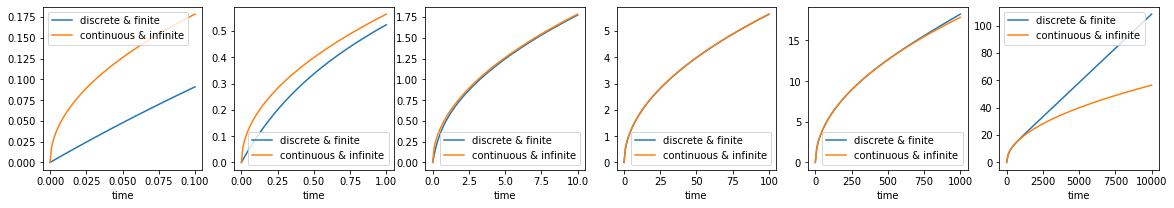

In [127]:
force = 1

fig, axs = plt.subplots(1, 6, figsize=[20, 3])
for ax, dt in zip(axs, [0.001, 0.01, 0.1, 1, 10, 100]):
    # Set up discrete model and generate trajectory
    discrete_model = rouse.Model(N=100, d=1, D=0)
    discrete_model.F[50] = force
    discrete_model.update_dynamics(dt=dt)
    
    conf = np.zeros((discrete_model.N, discrete_model.d))
    x = [conf[50]]
    for _ in range(100):
        conf = discrete_model.evolve(conf)
        x.append(conf[50])
    x_discrete = np.array(x)
    t = dt*np.arange(len(x_discrete))

    # Set up continuous model and generate trajectory
    continuous_model = rousepull.ForceInference(t)
    f = force*np.ones(len(t))
    f[0] = 0 # should always be true (chain is in equilibrium before the experiment)
    x_continuous = continuous_model._generate(f)
    x_continuous = x_continuous / np.sqrt(np.pi) # take care of the prefactor to get actual match with discrete model

    # Plot both
    ax.plot(t, x_discrete, label='discrete & finite')
    ax.plot(t, x_continuous, label='continuous & infinite')
    ax.legend()
    ax.set_xlabel('time')
    
plt.show()

The force response in the discrete model becomes linear both for very short and very long times: over short time scales, we pull on a single monomer, but do not displace it far enough to significantly move the others; over long time scales, we pull the whole chain. Inbetween these two limits we get good agreement with the continuous model.

The continuous (and infinite) chain, on the other hand, produces a square root response on any time scale; this is expected, since it is scale-free. At a technical level, this means that we cannot construct a length scale from the model constants.

<div class="alert alert-block alert-info">
    <b>Side Quest 5.0</b><br>
    The model constants of the continuous Rouse chain are $\gamma$ and $\kappa$. What units do these constants have? Demonstrate that it is impossible to construct a length scale from them.
</div>

<div class="alert alert-block alert-info">
    <b>Side Quest 5.1</b><br>
    Show that we still cannot build a length scale if we add a thermal energy scale $k_\text{B}T$ to the model constants.
</div>

<details>
    <summary>Solution to Side Quest 5</summary><br>
    Recall the equation of motion (without external force)
    $$
    \gamma\partial_t x = \kappa\partial_s^2 x\,.
    $$
    Dimensionally, both sides should be a force density over the backbone coordinate $s$; which we assign the auxiliary unit $S$. Together with $L$ for length, $T$ for time, and $F$ for force, we get
    $$
    [\gamma]\frac{L}{T} \oAverset{!}{=} [\kappa]\frac{L}{S^2} \overset{!}{=} \frac{F}{S}\,,
    $$
    which we can solve as
    $$
    [\gamma] = \frac{FT}{LS}\,,\qquad [\kappa] = \frac{FS}{L}\,.
    $$
    Let's try to construct a length scale $X := \gamma^a \kappa^b$. Dimensionally:
    $$
    L = [X] = [\gamma]^a [\kappa]^b = F^{a+b} T^a L^{-a-b} S^{-a+b}\,.
    $$
    Since all the dimensions are independent*, all the exponents have to match between the left and right hand side, giving the system
    $$
    a+b = 0\,,\qquad a = 0\,,\qquad -a-b = 1\,,\qquad -a+b = 0\,.
    $$
    Adding the first and third equations gives 0 = 1, a contradiction. It is thus impossible to construct a length scale out of the model constants of the continuous (and infinite) Rouse chain.<br>
    If we add the thermal energy $k_\text{B}T$ with units $[k_\text{B}T] = FL$ to the mix, we get
    $$
    L = [X] = [\gamma]^a [\kappa]^b [k_\text{B}T]^c = F^{a+b+c} T^a L^{-a-b+c} S^{-a+b}\,,
    $$
    giving
    $$
    a+b+c = 0\,,\qquad a = 0\,,\qquad -a-b+c = 1\,,\qquad -a+b = 0\,.
    $$
    Adding the second and fourth equation gives $b=0$, such that the first and third equations become $0 = c = 1$, which is still a contradiction. So the continuous Rouse model remains scale-free, even at finite temperature.
    <br><br>
    <font size=1>* Note: in SI units we would use a mass dimension $M$ instead of force $F = MLT^{-2}$; the result is the same.</font>
</details>

The scale-free property makes certain arguments extremely simple. Consider a continuous (and infinite) Rouse chain; we know from Task 8.2 that under a sustained external force $f$ applied at a defined point, that point moves as
$$
x(t) = A f t^{0.5}\,,
$$
with $A = 1/\sqrt{\pi\gamma\kappa}$ a combination of model constants. What happens if, instead of a constant external force we drive the system with
thermal kicks $\xi(s, t)$, whose strength is given by the thermal energy $k_\text{B}T$?

Because the thermal drive is random with $\left\langle\xi(s, t)\right\rangle = 0$, calculating the average position of any locus (as we did for the force response) does not make much sense; it will just be zero. The fluctuations around that mean, however, will be interesting. They are usually quantified by the Mean Squared Displacement
$$
\text{MSD}(\Delta t) := \left\langle \left(x(t+\Delta t) - x(t)\right)^2\right\rangle\,,
$$
which gives the average step size of the locus over a given time window (you might recognize the similarity to $R^2(\Delta s)$ which we used above to quantify polymer conformations).

Because the thermally driven Rouse chain is still scale-free (c.f. Side Quest 5.1), the MSD of any locus on the chain has to be a power law:
$$
\text{MSD}(\Delta t) = \Gamma\Delta t^\mu\,,
$$
with $\Gamma$ some combination of model constants (c.f. $A$ above), including $k_\text{B}T$.

<div class="alert alert-block alert-warning">
    <b>Task 10.0</b><br>
    What units do $\Gamma$, $A$, and $k_\text{B}T$ have? Can you build a length scale out of them?
</div>

<div class="alert alert-block alert-warning">
    <b>Task 10.1</b><br>
    Generalize the treatment from Task 10.0, by assuming a force response scaling as $x(t) = A f^\psi t^\rho$.
</div>

<details>
    <summary>Solution to Task 10</summary><br>
    We will treat the general case right away; the solution to Task 10.0 is found by setting $\psi=1$ and $\rho=0.5$.<br>
    The units of the constants are clear from the defining equations:
    $$
    [\Gamma] = \frac{L^2}{T^\mu}\,,\qquad [A] = \frac{L}{F^\psi T^\rho}\,,\qquad [k_\text{B}T] = FL\,.
    $$
    Trying to construct a length scale $X$ gives
    $$
    L = [X] = [\Gamma]^a [A]^b [k_\text{B}T]^c = F^{-b\psi+c} T^{-a\mu-b\rho} L^{2a+b+c}\,,
    $$
    leading to
    $$
    c = b\psi\,,\qquad a\mu+b\rho = 0\,,\qquad 2a+b+c = 1\,,
    $$
    which in turn can be simplified to
    $$
    a = -b\frac{\rho}{\mu}\,,\qquad b\left(1+\psi-2\frac{\rho}{\mu}\right) = 1\,,\qquad c = b\psi\,.
    $$
    So, as long as $1+\psi-2\frac{\rho}{\mu} \neq 0$, we can solve:
    $$
    a = \left(\frac{\mu}{\rho}(1+\psi) - 2\right)^{-1}\,,\qquad b = \left(1+\psi - 2\frac{\rho}{\mu}\right)^{-1}\,,\qquad c = \left(\frac{1}{\psi} + 1 - 2\frac{\rho}{\mu}\right)^{-1}\,.
    $$
    But wait! This means that we can actually construct a length scale! But we showed in Side Quest 5.1 that the thermally driven Rouse chain is still scale-free; this was the reason we could write the MSD as a power law in the first place. So if the system for $(a, b, c)$ is solvable, we get a contradiction; this does not happen only if $1+\psi-2\frac{\rho}{\mu} = 0$, which ensures that the second equation in the simplified system reads $0 = 1$. Rewriting, we found that the scale-free property of the continuous Rouse chain enforces
    $$
    \mu = \frac{2\rho}{1+\psi}\,.
    $$
    Specifically, for linear force response (which seems most reasonable, even for generalized models), we find that $\mu = \rho$. The exponents on MSD and force response scaling should be the same.<br>
    We have thus found a relation between the responses to an external force and thermal kicks; intuitively it seems clear that there should be some connection between these.
</details>

<div class="alert alert-block alert-info">
    <b>Side Quest 6</b><br>
    Construct a relationship between $R^2(\Delta s) = G^2\Delta s^2$ and the contact frequency scaling $P(\Delta s) = Qv_c\Delta s^{-\gamma}$ (which gives the probability of finding two loci which are separated by $\Delta s$ along the backbone close in physical space; specifically, their distance vector should be within the "contact volume" $v_c\propto r_c^d$, $d$ being spatial dimension).
</div>

<details>
    <summary>Solution to Side Quest 6</summary><br>
    Checking dimensions:
    $$
    [G^2] = \frac{L^2}{S^{2\nu}}\,,\qquad [Q] = \frac{S^\gamma}{L^d}\,.
    $$
    Attempt to construct a length scale:
    $$
    L = [X] = [G^2]^a [Q]^b = L^{2a-bd} S^{-2a\nu+b\gamma}\,,
    $$
    which gives
    $$
    2a-bd = 1\,,\qquad b\gamma = 2a\nu\,.
    $$
    Substituting equation two into one:
    $$
    2a\left(1-\frac{d\nu}{\gamma}\right) = 1\,,
    $$
    which is unsolvable if and only if the term in brackets is zero; which we can rewrite as
    $$
    \gamma = d\nu\,.
    $$
    We have thus demonstrated that, in 3D, a contact frequency scaling $P(\Delta s)\propto \Delta s^{-1}$ corresponds to $R(\Delta s)\propto \Delta s^\frac{1}{3}$.
</details>

<div class="alert alert-block alert-info">
    <b>Side Quest 7</b><br>
    Consider a scale-free polymer model where
    $$
    R^2(\Delta s) = G^2\Delta s^{2\nu}\,,\qquad \text{MSD}(\Delta t) = \Gamma\Delta t^\mu\,,\qquad \text{MSD}_\text{coil}(\Delta s, \Delta t) = D\Delta s^{-\delta}\Delta t^\alpha\,,
    $$
    where $\text{MSD}_\text{coil}(\Delta s, \Delta t)$ describes the long-time diffusion of a finite size coil (effectively this is a test particle for the solvent). Show by dimensional analysis that
    $$
    \mu = \frac{2\nu\alpha}{2\nu+\delta}\,.
    $$
    This relationship describes the relationships between structure of the coil ($\nu$), single-locus dynamics ($\mu$), and solvent interactions ($\alpha$ and $\delta$).
</div>

<details>
    <summary>Solution to Side Quest 7</summary><br>
    Checking dimensions:
    $$
    [G^2] = \frac{L^2}{S^{2\nu}}\,,\qquad [\Gamma] = \frac{L^2}{T^\mu}\,,\qquad [D] = \frac{L^2 S^\delta}{T^\alpha}\,.
    $$
    Attempt to construct a length scale:
    $$
    L = [X] = [G^2]^a [\Gamma]^b [D]^c = T^{-b\mu-c\alpha} L^{2a+2b+2c} S^{-2a\nu+c\delta}\,,
    $$
    which gives
    $$
    b\mu+c\alpha = 0\,,\qquad a+b+c = \frac{1}{2}\,,\qquad c\delta = 2a\nu\,.
    $$
    Solving the first and third equation for $b$ and $a$, respectively, and substituting into equation two gives
    $$
    c\left(\frac{\delta}{2\nu} - \frac{\alpha}{\mu} + 1\right) = \frac{1}{2}\,,
    $$
    which is unsolvable if and only if the term in brackets is zero; which we can rewrite as
    $$
    \mu = \frac{2\nu\alpha}{2\nu + \delta}\,.
    $$
</details>